In [19]:
from simulation.allen import allen_cahn_next_step
import numpy as np
from matplotlib import pyplot as plt
from utils import GRF1D
import torch


# Parameters
nx = 256
xmin = 0.0
xmax = 2.0
x = np.linspace(xmin, xmax, nx)
dx = (xmax - xmin) / (nx - 1)

# # Initial condition (you can replace this with any valid initial condition)
params = torch.randn(1, nx)
u = GRF1D(params)
u = u[0].numpy()

# # Compute the next time step
# traj = [u]
# for _ in range(20000):
#     traj.append(allen_cahn_next_step(traj[-1], x, xi, nu, dt))
# # u_next = allen_cahn_next_step(u, x, xi, nu, dt)

# plt.figure()
# plt.imshow(np.array(traj).T, aspect='auto')
# plt.colorbar()


# Allen-Cahn parameters
xi = 0.015
nu = 1.0
dt = 1e-5

# Initial condition (you can modify this to suit your problem)
# u = np.sin(2 * np.pi * x)  # Example: sine wave initial condition

# Time stepping loop (run for a few steps)
traj = [u]
n_steps = 1000
for step in range(n_steps):
    traj.append(allen_cahn_next_step(traj[-1], dx, xi, nu, dt))


# plt.plot(x, u)
# # At this point, 'u' contains the solution after 'n_steps' time steps

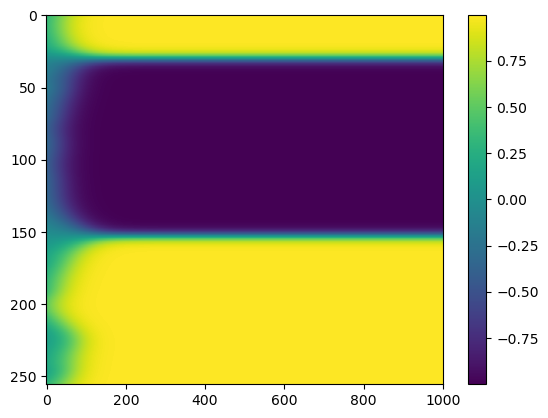

In [20]:
plt.figure()
plt.imshow(np.array(traj).T, aspect='auto')
plt.colorbar()

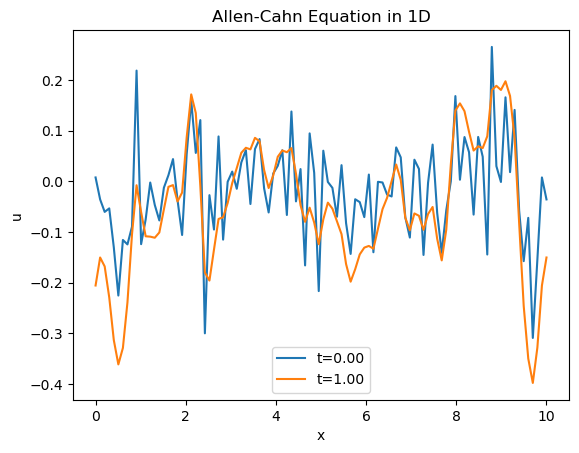

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 10.0              # Length of the domain
Nx = 100              # Number of spatial grid points
dx = L / Nx           # Spatial resolution
epsilon = 0.01        # Diffusion coefficient
dt = 0.01             # Time step size
T = 2.0               # Final time
Nsteps = int(T / dt)  # Number of time steps

# Spatial grid
x = np.linspace(0, L, Nx)

# Initial condition: random perturbation around u = 0
u = 0.1 * np.random.randn(Nx)

# Apply periodic boundary conditions
def apply_periodic_bc(u):
    u[0] = u[-2]
    u[-1] = u[1]
    return u

# Right-hand side of the Allen-Cahn equation
def rhs_ac(u, dx, epsilon):
    # Second derivative with central finite difference
    u_xx = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
    # Nonlinearity
    f_prime = u**3 - u
    return epsilon * u_xx - f_prime

# Time-stepping loop
for n in range(Nsteps):
    # Compute the right-hand side
    u_rhs = rhs_ac(u, dx, epsilon)
    # Forward Euler step
    u = u + dt * u_rhs
    # Apply periodic boundary conditions
    u = apply_periodic_bc(u)
    
    # Plot the solution at intervals
    if n % 100 == 0:
        plt.plot(x, u, label=f't={n*dt:.2f}')

# Plot final solution
plt.xlabel('x')
plt.ylabel('u')
plt.title('Allen-Cahn Equation in 1D')
plt.legend()
plt.show()
